Preamble to enable plotting
===

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import itertools
from scipy import interpolate


Create Random Lipschitz Functions for Testing
=====================

Intro
------

The first part of testing is to make some functions generating the test input. Since the optimization algorithm I envision works only on Lipschitz continuous functions, I must generate only such functions. Since sampling uniformly from the set of all functions is impractical (and likely impossible) I chose to sample instead from the set of piecewise linear functions on a bounded interval. (I chose a bounded interval because the extant optimization functions work on bounded intervals.) My construction also limits the range of the left-most value to lie in an interval.

A piecewise-linear function is Lipschitz continuous with a minimum positive Lipschitz constant of K if all of its component line segments have a slope between K and -K and if at least one has a slope whose absolute value is K.

To construct such a function, I first chose the x locations of the control points which I made uniform in the interval plus the two end-points of the interval. Then I chose one of the control points to have maximum slope. Finally, I started by assigning a random value to the left endpoint. Then, for each subsequent point, I chose uniformly from the set of points that would give an acceptable slope.

In [3]:
class Point:
    """A 2 dimensional point"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "Point("+str(self.x)+","+str(self.y)+")"

In [4]:
def flatten(container):
    for i in container:
        if isinstance(i, list) or isinstance(i, tuple):
            for j in flatten(i):
                yield j
        else:
            yield i

In [5]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [6]:
def lipschitzControlPoints(numPoints, K):
    """The control points for a piecewise linear function on 0..1 whose Lipschitz constant is K
    
       return a sequence of Point objects that when connected by lines form a Lipschitz continuous function whose
       minimum positive (or maximum negative) constant is K and whose first point is chosen uniformly in the 
       interval [0,1]
    
       numPoints the number of points to generate: must be 2 or more
    
       K   the constant such that abs(x0-x1) <= k(f(x0)-f(x1))
    """
    xval=[0,1];xval.extend([rng.uniform(0,1) for i in range(1,numPoints-1)])
    xval.sort()
    xWithMaxK = rng.choice(xval[1:]) # This point will have a constant of exactly K
    def nextPt(x, y, newx):
        """Choose a random y value for the next point meeting the Lipschitz condition """
        dx = abs(newx-x)
        maxy = y + dx*K
        miny = y - dx*K
        if newx == xWithMaxK:
            return rng.choice([miny, maxy]) # This point will have a constant of exactly K
        else:
            return rng.uniform(miny, maxy)
    
    yval = [0] * len(xval)
    yval[0] = 0 # rng.uniform(0,1)
    for i in range(1,len(xval)):
        yval[i] = nextPt(xval[i-1], yval[i-1], xval[i])
    return [Point(i[0], i[1]) for i in zip(xval, yval)]
    

In [7]:
def slopes(points):
    """Takes a set of control points and returns the slope for each line-segment (n-1 segments for n points)"""
    return [(p[1].y-p[0].y)/(p[1].x-p[0].x) for p in pairwise(points)]

In [8]:
def lipschitzConstant(points):
    """Takes a set of control points and returns the minimum positive Lipschitz constant for that set"""
    return max([abs(slope) for slope in slopes(points)])

Bench Test
---

In [9]:
cp=lipschitzControlPoints(5,3); cp

[Point(0,0),
 Point(0.3496040916353408,0.6993442759142614),
 Point(0.4058363262850573,0.8680409798634109),
 Point(0.7380840046607079,0.5618136171566089),
 Point(1,0.4585312672618187)]

In [10]:
lipschitzConstant(cp)

3.0

(-2, 2)

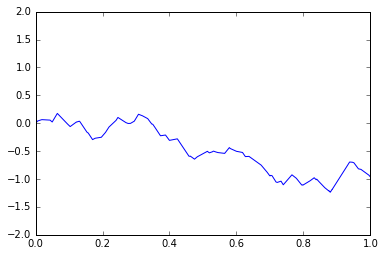

In [11]:
cp=lipschitzControlPoints(100,10)
y = [p.y for p in cp]
plt.plot([p.x for p in cp],y)
plt.ylim([y[0]-2,y[0]+2]) # Without this, the autoscaling makes all runs look the same

Add Box Class
=======

Intro
---

The DIRECT algorithm - which I would like to improve works on intervals anchored at the center point that it calls rectangles. In the full n-dimensional case these are hyperrectangles. It is faster to type Box, so that is what I will name my hyperrectangle class. 

I am starting with a simple box class for 1 dimension. If everything works well in 1D, I'll move up to n-dimensions. The box can divide itself in 3 (with only 2 more function calls), give the lower bound on the function value in the box and give the maximum overestimate of the function minumum by taking the minimum in the box. Both of the bounds require global information in the form of K, a Lipschitz constant for the function being evaluated.

In [12]:
class Box:
    def __init__(self, center, width):
        self.center = center
        self.width = width
    def divide(self, function):
        new_width = self.width / 3
        left_x = self.center.x - self.width/2 + new_width/2
        left = Box(Point(left_x, function(left_x)), new_width)
        right_x = self.center.x + self.width/2 - new_width/2
        right = Box(Point(right_x, function(right_x)), new_width)
        
        return (left, Box(self.center, new_width), right)
    def lowerBound(self, K):
        """Return the lower bound of the function on this box assuming that center is on 
        the function and K is a positive Lipschitz constant for the function"""
        return self.center.y-self.maxErr(K)
    def maxErr(self, K):
        """Return the maximum error between taking the center of this box as the optimum and finding the
        real optimum within the box assiming that K is a positive Lipschitz constant for the function"""
        return (self.width/2)*K
    def __repr__(self):
        return "Box("+str(self.center)+","+str(self.width)+")"

Bench Test
===

To test the box, I start with a unit box on the interval -18, 18 and put it through its paces using $f(x)=x^2$. In this case, the Lipschitz constant is $\max \left | \frac{df}{dx}(x) \right |$. Since $\left | \frac{df}{dx}(x) \right | = \left | 2x \right | = 2\left| x \right|$, the minimum Lipschitz constant is 36 on this interval. (Note that when not on a bounded interval, even such a simple function as $x^2$ is not Lipschitz continuous - it is the limitation to a bounded interval that makes it useful.)

In [13]:
b=Box(Point(0,0),36)
globalK=36

Note that the lower bound here is particularly bad because we started at the minimum with a wide interval.

In [14]:
b.lowerBound(globalK)

-648.0

In [15]:
b.maxErr(globalK)

648.0

Dividing the interval will produce improved bounds

In [16]:
xsq=lambda x:x*x

In [17]:
divided = b.divide(xsq); divided

(Box(Point(-12.0,144.0),12.0),
 Box(Point(0,0),12.0),
 Box(Point(12.0,144.0),12.0))

In [18]:
[(d.lowerBound(globalK),d.maxErr(globalK)) for d in divided]

[(-72.0, 216.0), (-216.0, 216.0), (-72.0, 216.0)]

Dividing everything again helps test the flatten function and ensure that everything is working as expected

In [19]:
divided = list(flatten([x.divide(xsq) for x in divided])); divided

[Box(Point(-16.0,256.0),4.0),
 Box(Point(-12.0,144.0),4.0),
 Box(Point(-8.0,64.0),4.0),
 Box(Point(-4.0,16.0),4.0),
 Box(Point(0,0),4.0),
 Box(Point(4.0,16.0),4.0),
 Box(Point(8.0,64.0),4.0),
 Box(Point(12.0,144.0),4.0),
 Box(Point(16.0,256.0),4.0)]

In [20]:
[(d.lowerBound(globalK),d.maxErr(globalK)) for d in divided]

[(184.0, 72.0),
 (72.0, 72.0),
 (-8.0, 72.0),
 (-56.0, 72.0),
 (-72.0, 72.0),
 (-56.0, 72.0),
 (-8.0, 72.0),
 (72.0, 72.0),
 (184.0, 72.0)]

In a real algorithm we'd only divide the subset most likely to give us an optimum. (The center point in this case - it both has the lowest bound and the lowest known value.)

In [21]:
divided = list(b.divide(xsq))
divided[1]=divided[1].divide(xsq)
divided = list(flatten(divided))
divided

[Box(Point(-12.0,144.0),12.0),
 Box(Point(-4.0,16.0),4.0),
 Box(Point(0,0),4.0),
 Box(Point(4.0,16.0),4.0),
 Box(Point(12.0,144.0),12.0)]

In [22]:
lowerBounds = [d.lowerBound(globalK) for d in divided]; lowerBounds

[-72.0, -56.0, -72.0, -56.0, -72.0]

Then we'd divide the ones tied for lowest lower-bound in turn.

In [23]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0, 72.0, -8.0, -56.0, -72.0, -56.0, -72.0]

In [24]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0,
 72.0,
 -8.0,
 -56.0,
 -22.22222222222222,
 -24.0,
 -22.22222222222222,
 -56.0,
 -72.0]

In [25]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0,
 72.0,
 -8.0,
 -56.0,
 -22.22222222222222,
 -24.0,
 -22.22222222222222,
 -56.0,
 -8.0,
 72.0,
 184.0]

In [26]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0,
 72.0,
 -8.0,
 4.444444444444443,
 -8.0,
 -16.88888888888889,
 -22.22222222222222,
 -24.0,
 -22.22222222222222,
 -56.0,
 -8.0,
 72.0,
 184.0]

In [27]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0,
 72.0,
 -8.0,
 4.444444444444443,
 -8.0,
 -16.88888888888889,
 -22.22222222222222,
 -24.0,
 -22.22222222222222,
 -16.88888888888889,
 -8.0,
 4.444444444444443,
 -8.0,
 72.0,
 184.0]

You can see how the suboptimal intervals were eventually excluded by the lower bound. In the next iteration, only the center interval (which we know contains the optimum) will be divided. But it will have competitors in several neighbor intervals - which will need to be investigated to tighten the bounds.

In [28]:
toDivide = min(enumerate(lowerBounds),key=lambda p:p[1])[0]
divided[toDivide]=divided[toDivide].divide(xsq)
divided = list(flatten(divided))
lowerBounds = [d.lowerBound(globalK) for d in divided]
lowerBounds

[184.0,
 72.0,
 -8.0,
 4.444444444444443,
 -8.0,
 -16.88888888888889,
 -22.22222222222222,
 -7.802469135802469,
 -8.0,
 -7.802469135802469,
 -22.22222222222222,
 -16.88888888888889,
 -8.0,
 4.444444444444443,
 -8.0,
 72.0,
 184.0]

Dirubert Algorithm
=====

Intro
---

In this section, I was trying to implement the Shubert algorithm (described in [this presentation](http://people.inf.ethz.ch/ybrise/data/talks/msem20080401.pdf)), in order to have a gold standard of what can be done with the correct global information. However, I got it mixed up in my head with the DIRECT algorithm and my own modifications, producing a Frankenstein's hybrid: the Dirubert algorithm.

My main mistake in the implementation is that I forgot that the Schubert algorithm works based on endpoints of the interval and chooses a lower-bound point within the interval as a next point to examine. Instead, I confused it with the DIRECT algorithm whose even box-division algorithm I've stepped through above.

It was still an interesting exercise, so I keep it here.

I implemented two variants of the algorithm for comparison: one which is greedy and explores the best known point until it's error makes it an acceptible optimum and one that always explores the point with the best lowest bound. During the implementation, I also wrote a version which, in each pass, divided all intervals that could beat the best lower bound at the beginning of the pass. That method used so many evaluations that I thought it would save significant evaluations if I checked the best interval one at a time and updated the best minimum each time. I am not so sure that saved much - and all those extra passes through the array are quite inefficient and hard to parallelize. Unfortunately, I edited that version as I was writing the step-by-step version. Maybe I'll recreate it.

I had hoped that the greedy variant would pay for its extra evaluations by: sometimes getting lucky, but more often, by finding good points that would eliminate large swaths of the search space. However, from my testing below, it seems that the lower bound usually improves so much by extra investigation that having extant lower points doesn't cut off much of the search space.

However, the difference between the greedy and the cautious variants seems to get less as K decreases. (From a few runs of each with $K=2$ and $K=20$).

In [29]:
def dirubertOneStep(boxes, minFound, stoppingErr, func, K, algo):
        # Among all the boxes whose lower bound is better than the best known that can be divided
        potentiallyOptimal = [boxPr for boxPr in enumerate(boxes) if 
                              boxPr[1].lowerBound(K) <= minFound and boxPr[1].maxErr(K) >= stoppingErr]
        if len(potentiallyOptimal) == 0:
            return boxes, minFound, False
        # Divide the box with the best center value
        if algo == 'greedy':
            toDivideIdx, toDivide = min(potentiallyOptimal, key=lambda p:p[1].center.y)
        else:
            toDivideIdx, toDivide = min(potentiallyOptimal, key=lambda p:p[1].lowerBound(K))
        newBoxes = toDivide.divide(func)
        boxes[toDivideIdx] = newBoxes[0]
        boxes.extend(newBoxes[1:])
        minFound = min([box.center.y for box in boxes])
        return boxes, minFound, True

def dirubertAlgorithm(center,width,err,func,K,algo):
    """Returns the best point (and all points tried) on func given that it is Lipschitz continuous with constant K 
    
       center the center x value of the interval over which the optimization takes place
       width the width of the interval over which the optimization takes place
       err the maximum error allowed - the iteration will stop when the lower bound is within 
           err of the best point
       func the function to optimize
       K the lipschitz constant for the interval
    """
    boxes = [Box(Point(center,func(center)), width)]
    minFound = min([box.center.y for box in boxes])
    minLowerBound = min([box.lowerBound(K) for box in boxes])
    minErr = minFound - minLowerBound
    moreToDivide = minErr > err
    while(moreToDivide):
        boxes, minFound, moreToDivide = dirubertOneStep(boxes, minFound, err, func, K, algo)
    best = [box for box in boxes if box.center.y == minFound]
    return best[0].center,boxes

In [30]:
def funcMinimum(points):
    """Returns the minimum of a function defined on a set of control points"""
    return min([p.y for p in points])

In [31]:
def funcFromPoints(points):
    """Makes a function that linearly interpolates for the control points (error for out of bounds)"""
    return interpolate.interp1d([p.x for p in points], [p.y for p in points],'linear')

Bench Test
---

### First test: $K=2$


I generate a function with 1,000,000 control points and constant K=2. The plot makes sure that funcFromPoints is indeed creating a function and lets me visually verify that the generated boxes are indeed tracking the original function and that the minimum appears in the expected neighborhood. It will be important when I change K in the next test that I keep the error bounds the same. Otherwise, $K=2$ is just as hard as $K=10$ when the required error is $\frac{1}{5}$ the size.

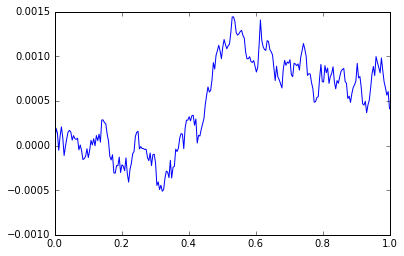

In [32]:
globalK=2
globalErr=0.00001
cp=lipschitzControlPoints(1000000,globalK)
fn=funcFromPoints(cp)
x = np.linspace(0, 1, 250)
plt.plot(x,[fn(xx) for xx in x])

Here is the true minimum - so I can check that the bounds were satisfied.

In [33]:
funcMinimum(cp)

-0.0005652086040200341

#### Greedy

Now run the greedy algorithm and plot its points searched. The darker areas have more function evaluations.

In [34]:
best,boxes=dirubertAlgorithm(0.5,1,globalErr,fn,globalK,'greedy'); (best,len(boxes))

(Point(0.32345170959711417,-0.0005626274685963203), 3269)

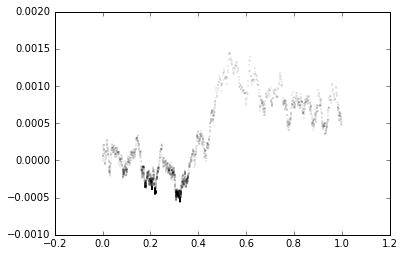

In [35]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)

#### Cautious

In [36]:
best,boxes=dirubertAlgorithm(0.5,1,globalErr,fn,globalK,'cautious'); (best,len(boxes))

(Point(0.32345170959711417,-0.0005626274685963203), 2865)

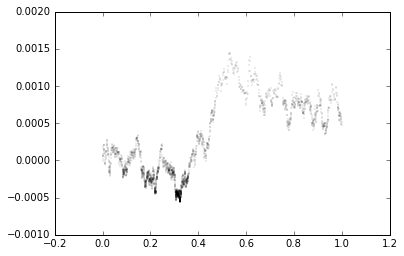

In [37]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)
#plt.scatter([box.center.x for box in boxes],[box.lowerBound(globalK) for box in boxes],s=.1)

### Second test: $K=20$

The next test should require significantly more evaluations because the function is rougher, thus the bounds are looser.

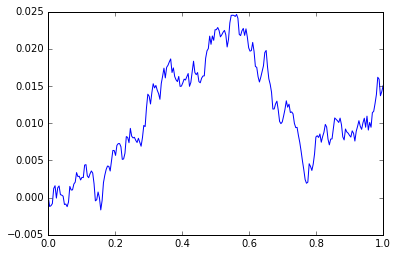

In [38]:
globalK=20
cp=lipschitzControlPoints(1000000,globalK)
fn=funcFromPoints(cp)
x = np.linspace(0, 1, 250)
plt.plot(x,[fn(xx) for xx in x])

In [39]:
funcMinimum(cp)

-0.0024675320535651316

#### Greedy

In [40]:
best,boxes=dirubertAlgorithm(0.5,1,globalErr,fn,globalK,'greedy'); (best,len(boxes))

(Point(0.004964803242504813,-0.002466931328578916), 2829)

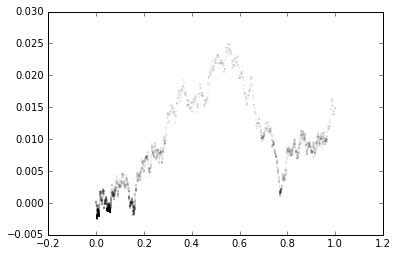

In [41]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)


#### Cautious

In [42]:
best,boxes=dirubertAlgorithm(0.5,1,globalErr,fn,globalK,'cautious'); (best,len(boxes))

(Point(0.004964803242504813,-0.002466931328578916), 2297)

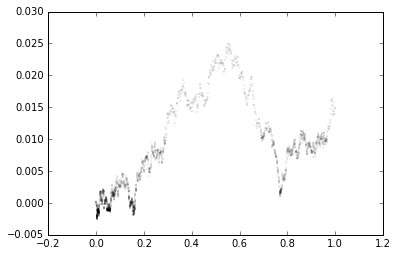

In [43]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)


Dirk algorithm
===

Intro
---

Dirk is just like the Dirubert algorithm except rather than knowing K a-priori it is re-estimated each time by treating the sampled points as a piecewise linear function.

In [86]:
def estimateLipschitzConstant(boxes):
    return lipschitzConstant(sorted([box.center for box in boxes],key=lambda c: c.x))
def dirkAlgorithm(center,width,err,func,algo):
    """Returns the best point (and all points tried) on func given that it is Lipschitz continuous with unknown constant
    
       center the center x value of the interval over which the optimization takes place
       width the width of the interval over which the optimization takes place
       err the maximum error allowed - the iteration will stop when the lower bound is within 
           err of the best point
       func the function to optimize
    """
    boxes = list((Box(Point(center,func(center)), width)).divide(func))
    minFound = min([box.center.y for box in boxes])
    estimatedK = estimateLipschitzConstant(boxes)
    moreToDivide = True
    while(moreToDivide):
        boxes, minFound, moreToDivide = dirubertOneStep(boxes, minFound, err, func, estimatedK, algo)
        estimatedK = estimateLipschitzConstant(boxes)
    best = [box for box in boxes if box.center.y == minFound]
    return best[0].center,boxes

Bench Test
----

### Try $K=2$

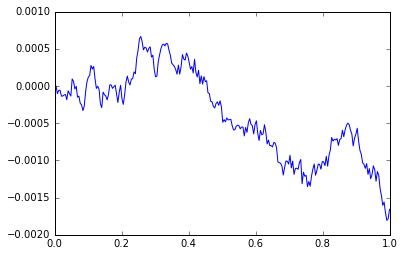

In [70]:
globalK=2
cp=lipschitzControlPoints(1000000,globalK)
fn=funcFromPoints(cp)
x = np.linspace(0, 1, 250)
plt.plot(x,[fn(xx) for xx in x])

In [71]:
globalBestPt = funcMinimum(cp)
globalBestPt = [p for p in cp if p.y == globalBestPt][0]
globalBestPt

Point(0.9929974666351908,-0.0018350380354508727)

#### Dirk algorithm

In [72]:
best, boxes = dirkAlgorithm(0.5, 1, globalErr, fn, 'cautious'); (best,len(boxes))

(Point(0.992997341191214,-0.0018348851902752913), 1227)

In [73]:
dirkDelta = Point(best.x - globalBestPt.x, best.y - globalBestPt.y); dirkDelta

Point(-1.2544397687275222e-07,1.52845175581e-07)

In [74]:
lipschitzConstant(sorted([box.center for box in boxes],key=lambda c: c.x))

1.1551481682540392

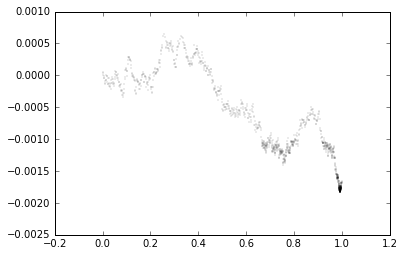

In [75]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)

#### Dirubert Algorithm (only the cautious variant)

In [76]:
best,boxes=dirubertAlgorithm(0.5,1,globalErr,fn,globalK,'cautious'); (best,len(boxes))

(Point(0.992997341191214,-0.0018348851902752913), 1869)

In [77]:
dirkDelta = Point(best.x - globalBestPt.x, best.y - globalBestPt.y); dirkDelta

Point(-1.2544397687275222e-07,1.52845175581e-07)

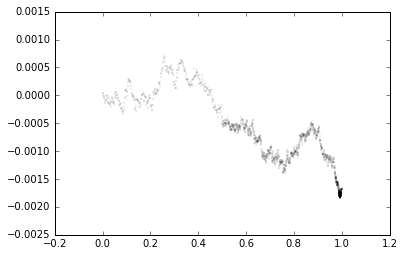

In [78]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)

### Trying $x^2$

I wanted to try the two algorithms against a nice function to see how well they did. So, I use Dirubert and Dirk against $x^2$

In [79]:
best,boxes=dirubertAlgorithm(1,2,globalErr,lambda x:x*x,4,'cautious'); (best,len(boxes))

(Point(1.881676423158921e-06,3.540706161472151e-12), 1991)

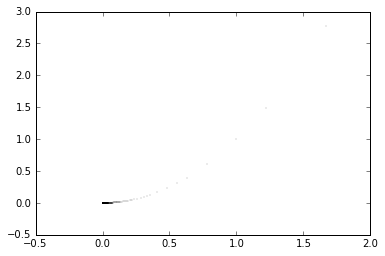

In [80]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)

In [87]:
best,boxes=dirkAlgorithm(1,2,globalErr,lambda x:x*x,'cautious'); (best,len(boxes))

(Point(1.881676423158921e-06,3.540706161472151e-12), 1623)

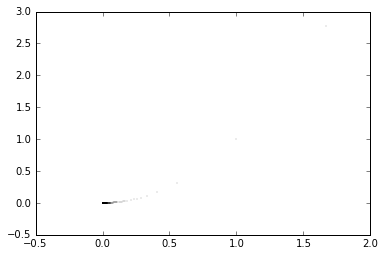

In [88]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.01)

In [89]:
estimateLipschitzConstant(boxes)

2.666666666666667

It still significantly underestimates the Lipschitz constant: $K=2\frac{2}{3}$ rather than $K=4$

This is probably why it evaluates so many less points.